# Set up

In [1]:
import cv2
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

from sklearn import cluster

import rasterio as rio
from rasterio.plot import show

from rastertodataframe import raster_to_dataframe
from osgeo import gdal

import os

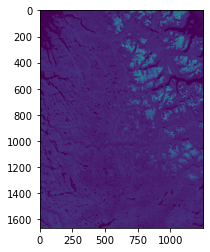

In [7]:
import rasterio
test = rasterio.open('../data_tests/labrador/raws/2019-09-25-00_00_2019-09-25-23_59_Sentinel-2_L2A_B8A_(Raw).tiff')
test_array = test.read(1)
plt.imshow(test_array)

# From True Color

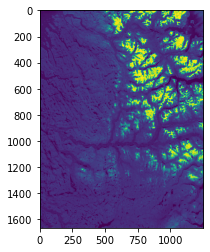

In [ ]:
#open tif true color convert to array
img = gdal.Open("../data_tests/labrador/2019-09-25-00_00_2019-09-25-23_59_Sentinel-2_L2A_True_color.tiff")
test_color = np.array(img.ReadAsArray())

#convert RGB array to greyscale
def grayConversion(image):
    b = image[0, ...]
    g = image[1, ...]
    r = image[2, ...]
    gray_img = 0.21 * r + 0.72 * g + 0.07 * b
    return gray_img

test_gray = grayConversion(test_color)
plt.imshow(test_gray)

## GeoCoordinates

[Stack overflow](https://stackoverflow.com/questions/27861197/how-to-i-get-the-coordinates-of-a-cell-in-a-geotif)

In [52]:


import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
path = '../data_tests/calgary/raws/2019-08-20-00_00_2019-08-20-23_59_Sentinel-2_L2A_B11_(Raw).tiff'

from osgeo import gdal
ds = gdal.Open(path, gdal.GA_ReadOnly)
T0 = Affine.from_gdal(*ds.GetGeoTransform())
ds = None  # close

# reference the pixel centre, so it needs to be translated by 50%:
T1 = T0 * Affine.translation(0.5, 0.5)
#transform from pixel coordinates to world coordinates, multiply the coordinates with the matrix
rc2xy = lambda r, c: T1 * (c, r)

In [67]:
ds.RasterXSize

1250

In [68]:
# All rows and columns
cols, rows = np.meshgrid(ds.RasterYSize, ds.RasterXSize)
# Get affine transform for pixel centres
T1 = T0 * Affine.translation( 0.5, 0.5 )
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: T1 * ( c, r )
# All eastings and northings -- this is much faster than np.apply_along_axis
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)


C:\Users\fynn\AppData\Local\Temp/ipykernel_18156/2048330568.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)


In [70]:
def get_geocoord(raws_path):
    
    #take first raw as example
    file_path = list(os.listdir(raws_path))[0]
    
    #open raw and get affine
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    T0 = Affine.from_gdal(*ds.GetGeoTransform())
    ds = None  # close
    
    # get shape of rows and columns
    cols, rows = np.meshgrid(ds.RasterYSize, ds.RasterXSize)
    
    # reference the pixel centre, so it needs to be translated by 50%:
    T1 = T0 * Affine.translation(0.5, 0.5)
    #transform from pixel coordinates to world coordinates, multiply the coordinates with the matrix
    rc2xy = lambda r, c: T1 * (c, r)
    
    # All eastings and northings -- this is much faster than np.apply_along_axis
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)
    
    #convert to columns
    lat = eastings.flatten()
    long = eastings.flatten()
    
    return lat, long

## K-means clustering

In [ ]:
#open image
sim_raster = rio.open('../data_tests/calgary/raws/2019-08-20-00_00_2019-08-20-23_59_Sentinel-2_L2A_B11_(Raw).tiff')
#sim_raster = rio.open('../data_tests/calgary/2019-08-20-00_00_2019-08-20-23_59_Sentinel-2_L2A_True_color.tiff')
print(sim_raster.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1250, 'height': 926, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.001527099609375, 0.0, -115.97991943359379,
       0.0, -0.0009522115040079597, 51.876490970614775)}


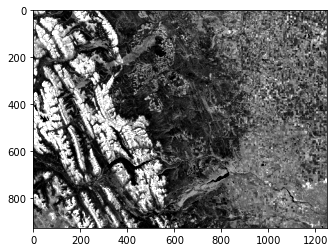

<AxesSubplot:>

In [63]:
# Read, enhance and show the image
sim_arr = sim_raster.read() # read the opened image
vmin, vmax = np.nanpercentile(sim_arr, (5,95))  # 5-95% contrast stretch# show the enhanced image
show(sim_arr, cmap='gray', vmin=vmin, vmax=vmax)

In [55]:
# create an empty array with same dimension and data type
imgxyb = np.empty((sim_raster.height, sim_raster.width, sim_raster.count), sim_raster.meta['dtype'])# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = sim_raster.read(band+1)
img1d=imgxyb[:,:,:3].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))

In [68]:
img1d = sim_arr.flatten().reshape(-1,1)

In [72]:
cl = cluster.KMeans(n_clusters=3) # create an object of the classifier
param = cl.fit(img1d) # train it
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(sim_arr.shape) # reshape labels to a 3d array (one band only)

In [16]:
img_cl[0].shape

(2134, 2500)

(-0.5, 2499.5, 2133.5, -0.5)

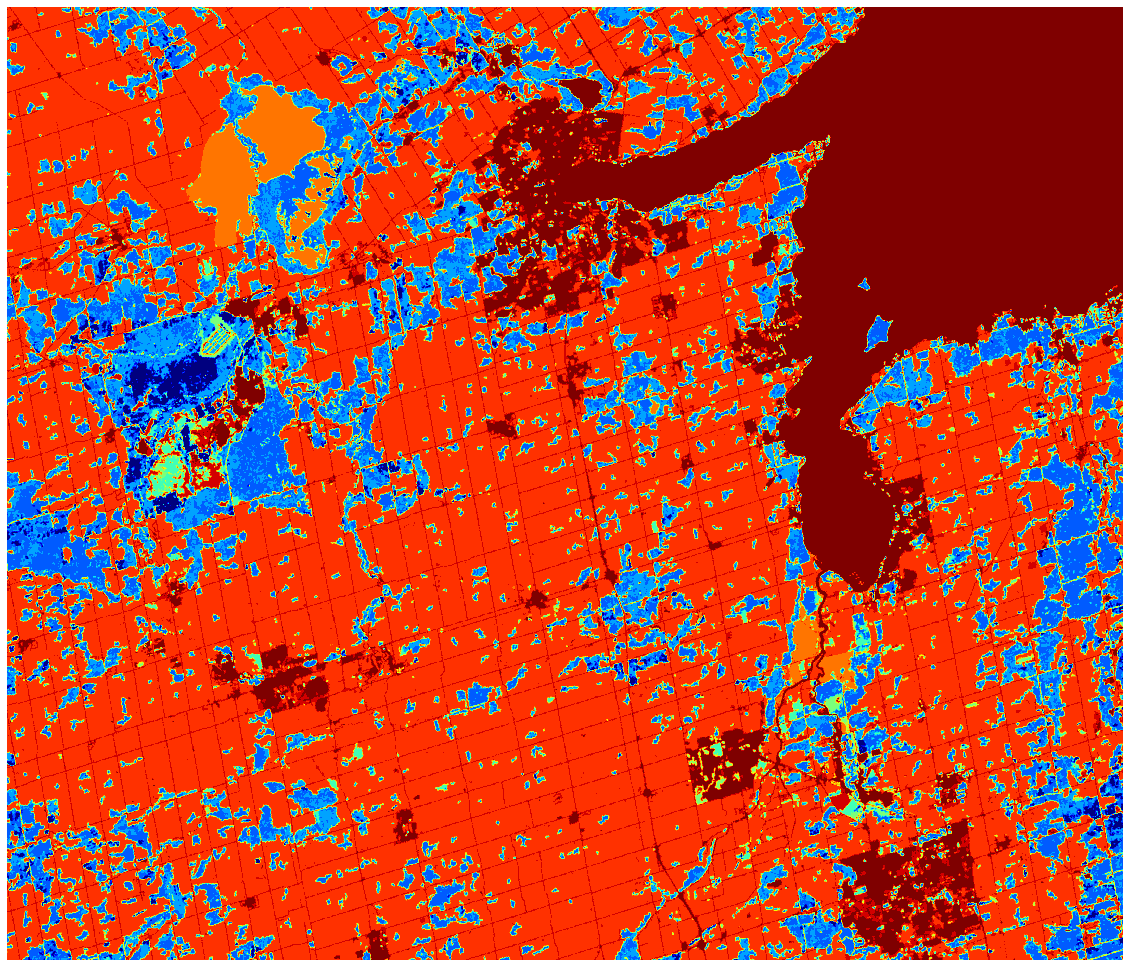

In [74]:
sim_true_raster = rio.open('../data_tests/simcoe_york/Simcoe_York_2019.tif')
sim_true_arr = sim_true_raster.read()
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors

plt.figure(figsize=[20,20])
plt.imshow(sim_true_arr[0], cmap=cmap)
plt.axis('off')

(-0.5, 1249.5, 925.5, -0.5)

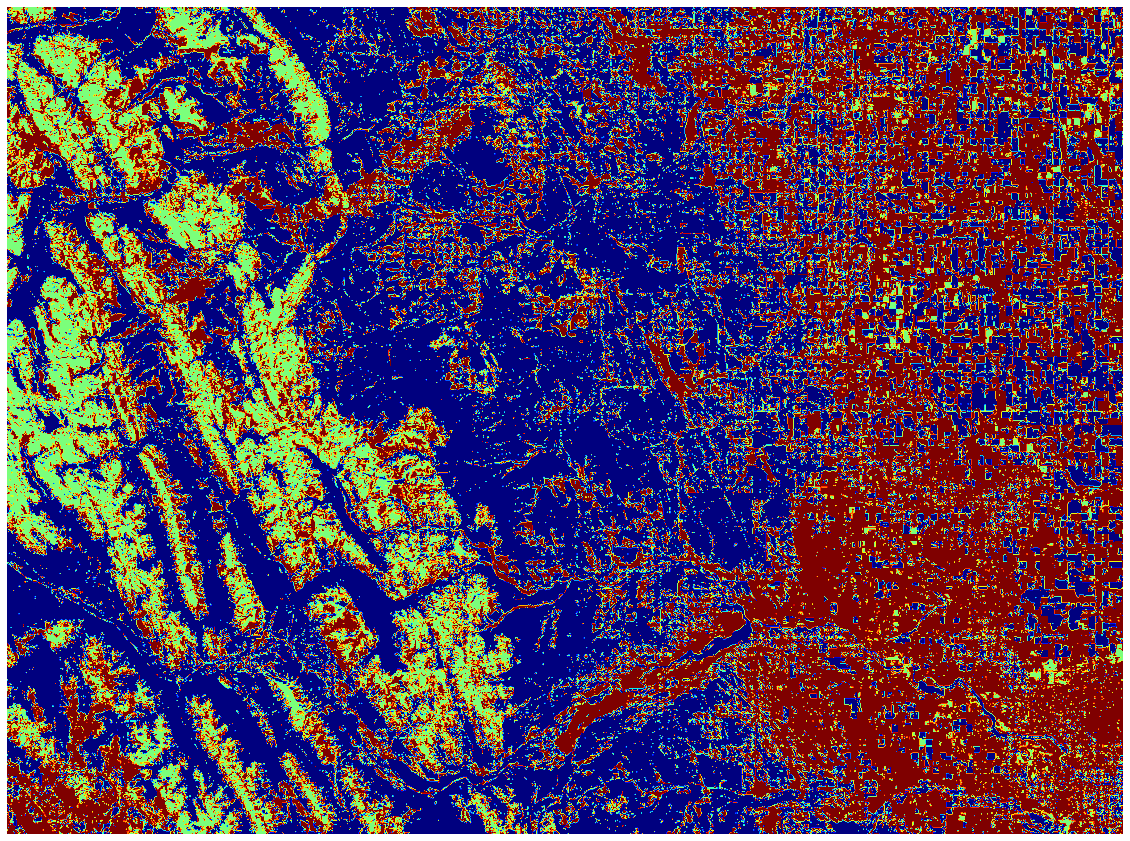

In [73]:
# Show the resulting array and save it as jpg image

plt.figure(figsize=[20,20])
plt.imshow(img_cl[0], cmap=cmap)
plt.axis('off')

# Filtering - Raw bands

## Gaussian

In [24]:
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter
from skimage.filters import difference_of_gaussians, gaussian
from scipy.signal import medfilt2d
def gaussian_raws(path_to_dir,  sigma = 1, nrcan_name = 'NRCAN_transformed.tif', index = [-14,-11]):
    raw_files = list(os.listdir(path_to_dir))

    gauss_df = pd.DataFrame()
    for i in raw_files:

        raw_img = gdal.Open(os.path.join(path_to_dir, i))
   
        rows = raw_img.RasterYSize
        cols = raw_img.RasterXSize
        
        raw_array = np.array(raw_img.ReadAsArray())
        
        raw_gauss = gaussian_filter(raw_array, sigma = sigma)
        
        raw_gauss = raw_gauss.flatten()
        gauss_df[i[index[0]:index[1]]] = raw_gauss
    
    nrcan_array = raster_to_dataframe(os.path.join(path_to_dir, '..', nrcan_name))
   
    print(nrcan_array.value_counts())
    gauss_df['y'] = nrcan_array.values
    return gauss_df
                
test_gauss = gaussian_raws('../data_tests/demo/raws', nrcan_name = 'land_cover.tif', index = [0, 3])


Band_1
14        1786474
1         1295963
5          754883
15         389203
8          327876
6          319587
18         304956
10          32747
17          24855
16           8532
255          4599
2             229
12             96
dtype: int64


In [15]:
#raster = gdal.Open("../data_tests/calgary/raws/2019-08-20-00_00_2019-08-20-23_59_Sentinel-2_L2A_B8A_(Raw).tiff")
raster = gdal.Open("../data_tests/demo/raws/B01.tif")
test_raw = np.array(raster.ReadAsArray())

In [28]:
#replace outliers
new_raw = test_raw.flatten()
outliers = (np.quantile(new_raw, q = 0.75) * 2)
new_raw[new_raw > outliers] = np.median(new_raw)
new_raw = new_raw.reshape(2100, 2500)

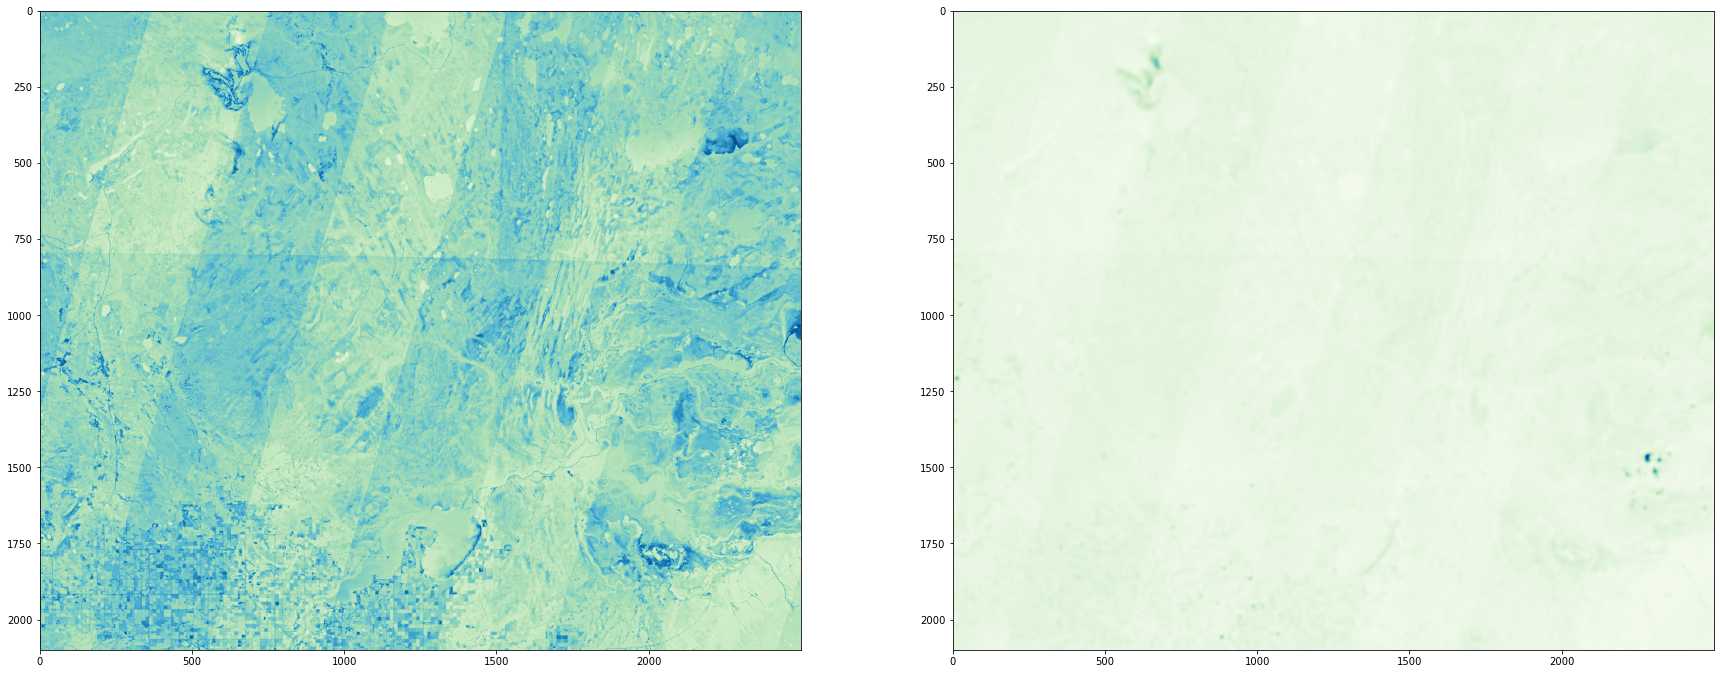

In [29]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

raw_gauss = gaussian(test_raw, sigma=5)

ax1.imshow(new_raw, cmap = 'GnBu')
ax2.imshow(raw_gauss, cmap = 'GnBu')

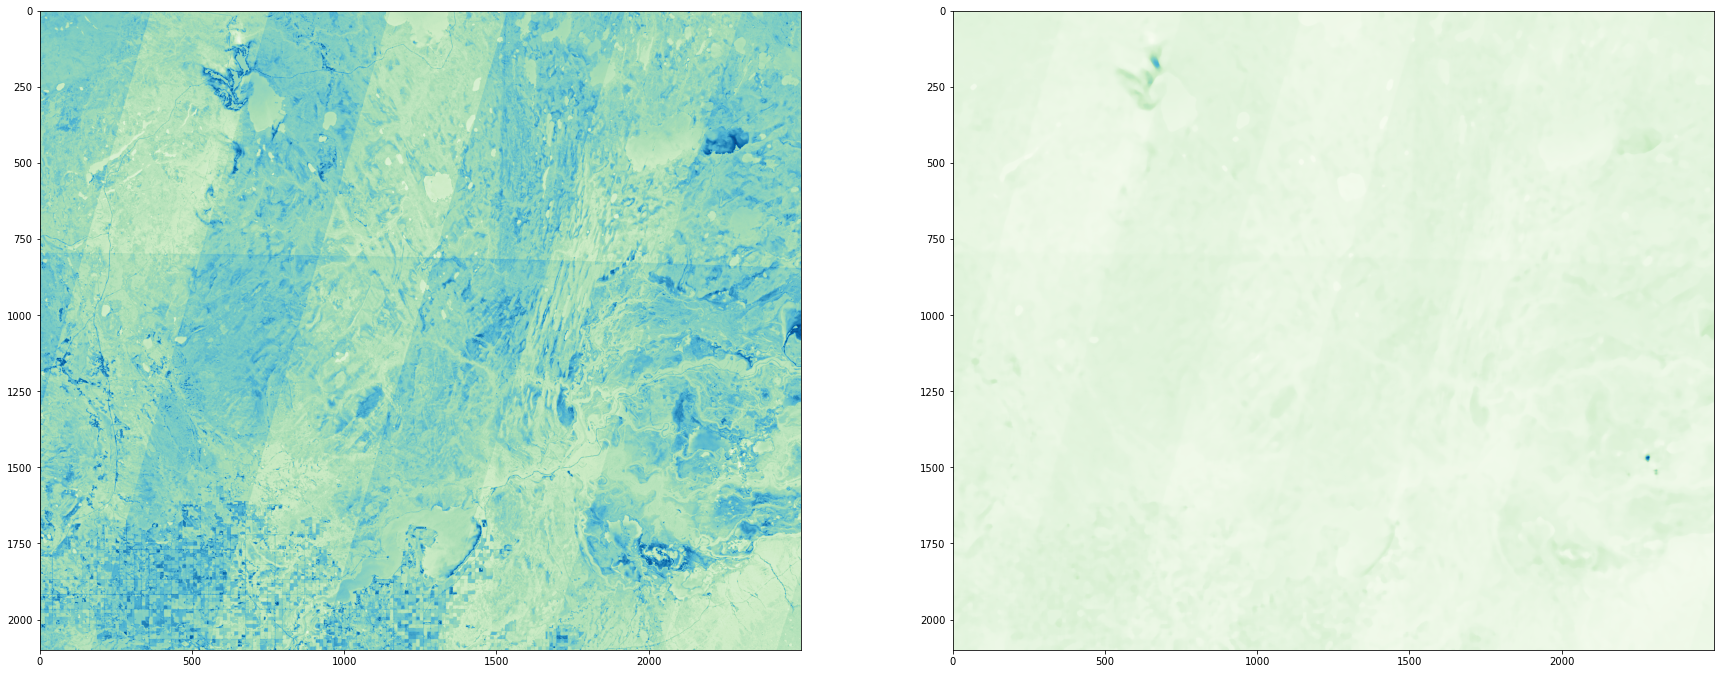

In [39]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

med_gauss = median_filter(test_raw, size = 20)

ax1.imshow(new_raw, cmap = 'GnBu')
ax2.imshow(med_gauss, cmap = 'GnBu')

In [ ]:
#custom functions
def clean_raws(dataframe):
    clean_all = pd.DataFrame()

    #for each category
    for category in dataframe.y.unique():
        #initialize new dataframe using first band of current category
        clean_df = dataframe.loc[dataframe['y'] == category]['B01']

        #get quartile range
        Q1 = clean_df.quantile(0.25)
        Q3 = clean_df.quantile(0.75)
        outlier = Q3 * 2
        #delete values not within
        clean_df = clean_df[clean_df < outlier].reset_index()
    
        #for every subsequent band do the same thing and merge
        for band in dataframe.columns[1:-1]:
            temp_df = dataframe.loc[dataframe['y'] == category][band]
            
            Q1 = temp_df.quantile(0.25)
            Q3 = temp_df.quantile(0.75)
            outlier = Q3 * 2

            temp_df = temp_df[temp_df < outlier].reset_index()
            clean_df = clean_df.merge(temp_df, how= 'inner', on = 'index')
        
        clean_df['y'] = category    
        #append each cleaned category dataframe to dict
        clean_all = pd.concat([clean_all, clean_df])
    
    return clean_all.drop('index', axis = 1)

# Edge detection

## Canny

Text(0.5, 1.0, 'Canny filter, $\\sigma=3$')

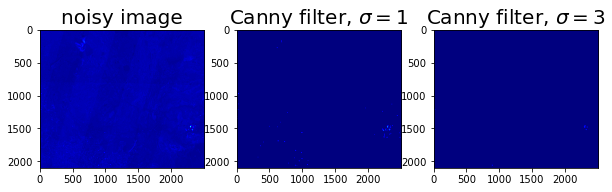

In [17]:
from skimage import feature

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(test_raw, sigma = 1)
edges2 = feature.canny(test_raw, sigma=3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(test_raw, cmap='jet')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='jet')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='jet')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

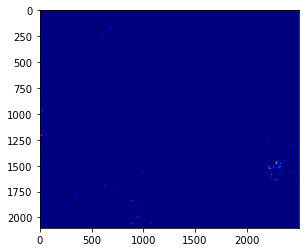

In [19]:
plt.imshow(edges1, cmap = 'jet')

Text(0.5, 1.0, 'Canny filter, $\\sigma=3$')

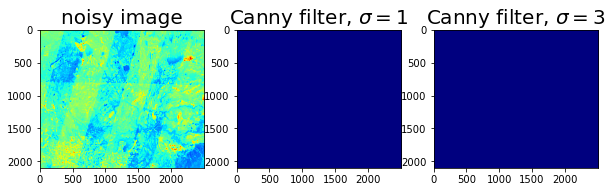

In [30]:
#apply gauss to test frame
gauss_test = gaussian(test_raw)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(new_raw, sigma = 1)
edges2 = feature.canny(new_raw, sigma=3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(new_raw, cmap='jet')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='jet')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='jet')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

# Segmentation

## Region based

Source code from [here](https://www.analyticsvidhya.com/blog/2021/09/image-segmentation-algorithms-with-implementation-in-python/)

Text(0.5, 1.0, 'elevation_map')

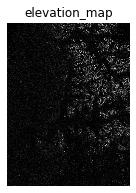

In [37]:
from skimage.filters import sobel
from skimage import morphology

elevation_map = sobel(test_gray)

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')

ax.axis('off')

ax.set_title('elevation_map')

C:\Users\fynn\Documents\anaconda\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\fynn\AppData\Local\Temp/ipykernel_5564/3103435438.py:33: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(labeled_raw, image=test_gray)


NameError: name 'margins' is not defined

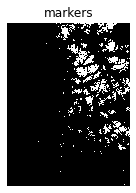

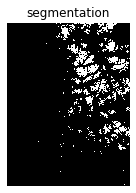

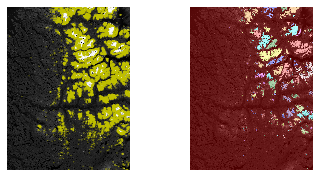

In [43]:
markers = np.zeros_like(test_gray)

markers[test_gray < 0.5] = 1

markers[test_gray > 0.5] = 2

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(markers, cmap=plt.cm.gray, interpolation='nearest')

ax.axis('off')

ax.set_title('markers')

segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')

ax.axis('off')

ax.set_title('segmentation')

from skimage.color import label2rgb

from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(segmentation - 1)

labeled_raw, _ = ndi.label(segmentation)

image_label_overlay = label2rgb(labeled_raw, image=test_gray)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax1.imshow(test_gray, cmap=plt.cm.gray, interpolation='nearest')

ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')

ax1.axis('off')

ax1.set_adjustable('box')

ax2.imshow(image_label_overlay, interpolation='nearest')

ax2.axis('off')

ax2.set_adjustable('box')

fig.subplots_adjust(**margins)

## Edge

C:\Users\fynn\AppData\Local\Temp/ipykernel_5564/569010145.py:13: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  raw_segments = slic(test_gray,


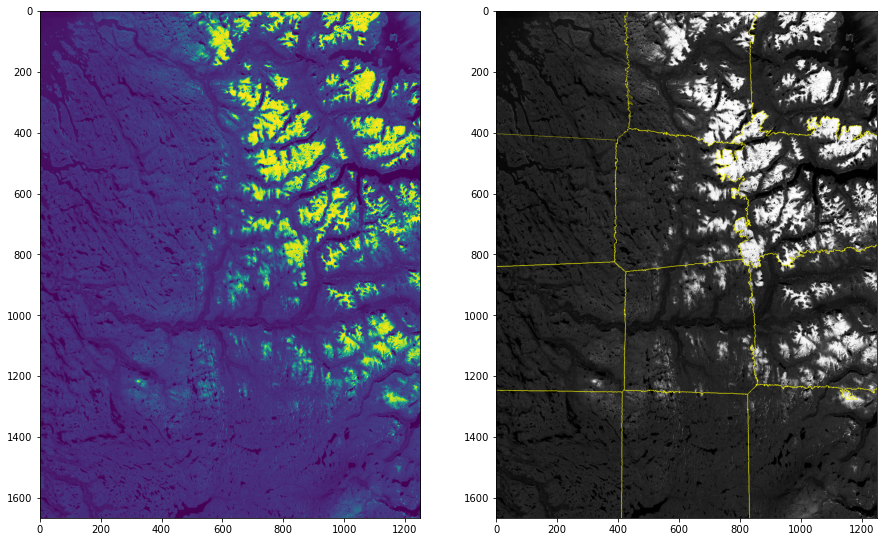

In [36]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries

# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Applying SLIC segmentation
# for the edges to be drawn over
raw_segments = slic(test_gray,
                          n_segments=12,
                          compactness=1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(test_gray)
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the ouput of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(test_gray, raw_segments))